In [ ]:
!pip install datasets seaborn transformers evaluate sentencepiece

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/course_work/pauq-main.zip" /content/pauq-main.zip
!unzip /content/pauq-main.zip

!cp "/content/drive/MyDrive/course_work/spider.zip" /content/spider.zip
!unzip /content/spider.zip

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    MT5Tokenizer,
    DataCollatorForSeq2Seq,
    HfArgumentParser,
    MBart50TokenizerFast,
    MBartTokenizer,
    MBartTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)
import evaluate

#### Загрузка данных и предварительный анализ

In [ ]:
# spider
dataset_name_spider = "spider"
train_gold = "/content/spider/train_spider.json"
train_others = "/content/spider/train_others.json"
dev_gold = "/content/spider/dev.json"

# pauq
dataset_name_pauq = "pauq"
pauq_train = "/content/pauq-main/dataset/pauq_train.json"
pauq_dev = "/content/pauq-main/dataset/pauq_dev.json"

In [ ]:
def data_gen(dataset_name, arr_files):
  jsons = []
  for file in arr_files:
    with open(file, encoding="utf-8") as f:
      jsons.append(json.load(f))
  if dataset_name == 'spider':
    for json_data in jsons:
        for sample in json_data:
          yield {
              "db_id": sample["db_id"],
              "query": sample["query"],
              "question": sample["question"],
              "query_toks": sample["query_toks"],
              "query_toks_no_value": sample["query_toks_no_value"],
              "question_toks": sample["question_toks"],
              }
  elif dataset_name == 'pauq':
    for json_data in jsons:
        for sample in json_data:
          yield {
              "id": sample["id"],
              "db_id": sample["db_id"],
              "source": sample["source"],
              "type": sample["type"],
              "query_en": sample["query"]["en"],
              "query_ru": sample["query"]["ru"],
              "question_en": sample["question"]["en"],
              "question_ru": sample["question"]["ru"],
              #"sql_en": sample["sql"]["en"],
              #"sql_ru": sample["sql"]["ru"],
              "query_toks_en": sample["query_toks"]["en"],
              "query_toks_ru": sample["query_toks"]["ru"],
              "query_toks_no_values_en": sample["query_toks_no_values"]["en"],
              "query_toks_no_values_ru": sample["query_toks_no_values"]["ru"],
              "question_toks_en": sample["question_toks"]["en"], 
              "question_toks_ru": sample["question_toks"]["ru"]
              }

In [ ]:
spider_data = pd.DataFrame(data_gen(dataset_name_spider, [train_gold, train_others]))
pauq_data = pd.DataFrame(data_gen(dataset_name_pauq, [pauq_train]))

##### Набор данных spider

In [ ]:
spider_data.head(5)

,db_id,query,question,query_toks,query_toks_no_value,question_toks
0,department_management,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...","[How, many, heads, of, the, departments, are, ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","[List, the, name, ,, born, state, and, age, of..."
2,department_management,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","[List, the, creation, year, ,, name, and, budg..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,"[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...","[What, are, the, maximum, and, minimum, budget..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...","[What, is, the, average, number, of, employees..."


In [ ]:
spider_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8659 entries, 0 to 8658
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   db_id                8659 non-null   object
 1   query                8659 non-null   object
 2   question             8659 non-null   object
 3   query_toks           8659 non-null   object
 4   query_toks_no_value  8659 non-null   object
 5   question_toks        8659 non-null   object
dtypes: object(6)
memory usage: 406.0+ KB


##### Набор данных pauq

In [ ]:
pauq_data.head(5)

,id,db_id,source,type,query_en,query_ru,question_en,question_ru,query_toks_en,query_toks_ru,query_toks_no_values_en,query_toks_no_values_ru,question_toks_en,question_toks_ru
0,TS_0001,department_management,spider-train,train,SELECT count(*) FROM head WHERE age > 56;,SELECT count(*) FROM head WHERE age > 56;,How many heads of the departments are older th...,Сколько руководителей отделов старше 56 лет?,"[select, count, (, *, ), from, head, where, ag...","[select, count, (, *, ), from, head, where, ag...","[select, count, (, *, ), from, head, where, ag...","[select, count, (, *, ), from, head, where, ag...","[How, many, heads, of, the, departments, are, ...","[Сколько, руководителей, отделов, старше, 56, ..."
1,TS_0002,department_management,spider-train,train,"SELECT name , born_state , age FROM head ORD...","SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads...","Перечислите имена, место рождения и возраст ру...","[select, name, ,, born_state, ,, age, from, he...","[select, name, ,, born_state, ,, age, from, he...","[select, name, ,, born_state, ,, age, from, he...","[select, name, ,, born_state, ,, age, from, he...","[List, the, name, ,, born, state, and, age, of...","[Перечислите, имена, ,, место, рождения, и, во..."
2,TS_0003,department_management,spider-train,train,"SELECT creation , name , budget_in_billions ...","SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac...","Укажите год создания, название и бюджет каждог...","[select, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","[List, the, creation, year, ,, name, and, budg...","[Укажите, год, создания, ,, название, и, бюдже..."
3,TS_0004,department_management,spider-train,train,"SELECT max(budget_in_billions) , min(budget_i...","SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...,Каков максимальный и минимальный бюджет отделов?,"[select, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...","[What, are, the, maximum, and, minimum, budget...","[Каков, максимальный, и, минимальный, бюджет, ..."
4,TS_0005,department_management,spider-train,train,SELECT avg(num_employees) FROM department WHER...,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...,Какова средняя численность сотрудников отделов...,"[select, avg, (, num_employees, ), from, depar...","[select, avg, (, num_employees, ), from, depar...","[select, avg, (, num_employees, ), from, depar...","[select, avg, (, num_employees, ), from, depar...","[What, is, the, average, number, of, employees...","[Какова, средняя, численность, сотрудников, от..."


In [ ]:
pauq_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       8800 non-null   object
 1   db_id                    8800 non-null   object
 2   source                   8800 non-null   object
 3   type                     8800 non-null   object
 4   query_en                 8800 non-null   object
 5   query_ru                 8800 non-null   object
 6   question_en              8800 non-null   object
 7   question_ru              8800 non-null   object
 8   query_toks_en            8800 non-null   object
 9   query_toks_ru            8800 non-null   object
 10  query_toks_no_values_en  8800 non-null   object
 11  query_toks_no_values_ru  8800 non-null   object
 12  question_toks_en         8800 non-null   object
 13  question_toks_ru         8800 non-null   object
dtypes: object(14)
memory usage: 962.6+ KB


In [ ]:
pauq_data['source'].value_counts()

spider-train           7000
spider-train-others    1659
addition                141
Name: source, dtype: int64

In [ ]:
pauq_data[pauq_data['source'] == 'addition'].head(5)

,id,db_id,source,type,query_en,query_ru,question_en,question_ru,query_toks_en,query_toks_ru,query_toks_no_values_en,query_toks_no_values_ru,question_toks_en,question_toks_ru
8659,B_0001,flight_4,addition,train,SELECT name FROM airlines WHERE active = 'Y',SELECT name FROM airlines WHERE active = 'Д',Names of active airlines,Названия действующих авиакомпаний,"[select, name, from, airlines, where, active, ...","[select, name, from, airlines, where, active, ...","[select, name, from, airlines, where, active, ...","[select, name, from, airlines, where, active, ...","[Names, of, active, airlines]","[Названия, действующих, авиакомпаний]"
8660,B_0002,flight_4,addition,train,SELECT COUNT(*) FROM airlines WHERE active = '...,SELECT COUNT(*) FROM airlines WHERE active = '...,How many active airlines are in Canada?,Сколько действующих авиакомпаний в Канаде?,"[select, count, (, *, ), from, airlines, where...","[select, count, (, *, ), from, airlines, where...","[select, count, (, *, ), from, airlines, where...","[select, count, (, *, ), from, airlines, where...","[How, many, active, airlines, are, in, Canada, ?]","[Сколько, действующих, авиакомпаний, в, Канаде..."
8661,B_0003,flight_4,addition,train,SELECT callsign FROM airlines WHERE active = 'N',SELECT callsign FROM airlines WHERE active = 'Н',What are callsigns of inactive airlines?,"Какие позывные используют авиакомпании, не явл...","[select, callsign, from, airlines, where, acti...","[select, callsign, from, airlines, where, acti...","[select, callsign, from, airlines, where, acti...","[select, callsign, from, airlines, where, acti...","[What, are, callsigns, of, inactive, airlines, ?]","[Какие, позывные, используют, авиакомпании, ,,..."
8662,B_0004,department_management,addition,train,SELECT COUNT(*) FROM management WHERE temporar...,SELECT COUNT(*) FROM management WHERE temporar...,How many temporary acting managements are there?,"Сколько у нас сейчас руководителей, временно и...","[select, count, (, *, ), from, management, whe...","[select, count, (, *, ), from, management, whe...","[select, count, (, *, ), from, management, whe...","[select, count, (, *, ), from, management, whe...","[How, many, temporary, acting, managements, ar...","[Сколько, у, нас, сейчас, руководителей, ,, вр..."
8663,B_0005,department_management,addition,train,SELECT COUNT(*) FROM management WHERE temporar...,SELECT COUNT(*) FROM management WHERE temporar...,Amount of temporary acting managements,"Количество руководителей, временно исполняющих...","[select, count, (, *, ), from, management, whe...","[select, count, (, *, ), from, management, whe...","[select, count, (, *, ), from, management, whe...","[select, count, (, *, ), from, management, whe...","[Amount, of, temporary, acting, managements]","[Количество, руководителей, ,, временно, испол..."


In [ ]:
pauq_data[pauq_data['query_toks_en'] != pauq_data['query_toks_ru']]

,id,db_id,source,type,query_en,query_ru,question_en,question_ru,query_toks_en,query_toks_ru,query_toks_no_values_en,query_toks_no_values_ru,question_toks_en,question_toks_ru
5,TS_0006,department_management,spider-train,train,SELECT name FROM head WHERE born_state != 'Cal...,SELECT name FROM head WHERE born_state != 'Юта',What are the names of the heads who are born o...,"Как зовут глав, родившихся за пределами штата ...","[select, name, from, head, where, born_state, ...","[select, name, from, head, where, born_state, ...","[select, name, from, head, where, born_state, ...","[select, name, from, head, where, born_state, ...","[What, are, the, names, of, the, heads, who, a...","[Как, зовут, глав, ,, родившихся, за, пределам..."
6,TS_0007,department_management,spider-train,train,SELECT DISTINCT T1.creation FROM department AS...,SELECT DISTINCT T1.creation FROM department AS...,What are the distinct creation years of the de...,"Каковы годы создания отделов, которыми руковод...","[select, distinct, t1.creation, from, departme...","[select, distinct, t1.creation, from, departme...","[select, distinct, t1.creation, from, departme...","[select, distinct, t1.creation, from, departme...","[What, are, the, distinct, creation, years, of...","[Каковы, годы, создания, отделов, ,, которыми,..."
9,TS_0010,department_management,spider-train,train,"SELECT T1.name , T1.num_employees FROM depart...","SELECT T1.name , T1.num_employees FROM depart...",Show the name and number of employees for the ...,Укажите фамилии и количество сотрудников для о...,"[select, t1.name, ,, t1.num_employees, from, d...","[select, t1.name, ,, t1.num_employees, from, d...","[select, t1.name, ,, t1.num_employees, from, d...","[select, t1.name, ,, t1.num_employees, from, d...","[Show, the, name, and, number, of, employees, ...","[Укажите, фамилии, и, количество, сотрудников,..."
12,TS_0013,department_management,spider-train,train,SELECT DISTINCT T1.age FROM management AS T2 J...,SELECT DISTINCT T1.age FROM management AS T2 J...,What are the distinct ages of the heads who ar...,Каков возраст всех действующих руководителей?,"[select, distinct, t1.age, from, management, a...","[select, distinct, t1.age, from, management, a...","[select, distinct, t1.age, from, management, a...","[select, distinct, t1.age, from, management, a...","[What, are, the, distinct, ages, of, the, head...","[Каков, возраст, всех, действующих, руководите..."
13,TS_0014,department_management,spider-train,train,SELECT T3.born_state FROM department AS T1 JOI...,SELECT T3.born_state FROM department AS T1 JOI...,List the states where both the secretary of 'T...,"Перечислите штаты, в которых родились и секрет...","[select, t3.born_state, from, department, as, ...","[select, t3.born_state, from, department, as, ...","[select, t3.born_state, from, department, as, ...","[select, t3.born_state, from, department, as, ...","[List, the, states, where, both, the, secretar...","[Перечислите, штаты, ,, в, которых, родились, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8769,F_0029,mountain_photos,addition,train,SELECT name FROM mountain WHERE Country = 'Eth...,SELECT name FROM mountain WHERE Country = 'Рос...,What are the mountains called in Ethiopia?,"Перечисли, как называются все горы в России.","[select, name, from, mountain, where, country,...","[select, name, from, mountain, where, country,...","[select, name, from, mountain, where, country,...","[select, name, from, mountain, where, country,...","[What, are, the, mountains, called, in, Ethiop...","[Перечисли, ,, как, называются, все, горы, в, ..."
8771,F_0041,voter_2,addition,train,SELECT candidate.LName FROM Student as voter J...,SELECT candidate.LName FROM Student as voter J...,Surnames of all candidates Tracey Kim voted fo...,"Фамилии всех кандидатов, за которых голосовал ...","[select, candidate.lname, from, student, as, v...","[select, candidate.lname, from, student, as, v...","[select, candidate.lname, from, student, as, v...","[select,

Таким образом, для обучения моделей можно использовать только один набор данных pauq, который является расширением набора данных spider

#### Изучение категориальных признаков

In [ ]:
analysis = pd.read_html("/content/pauq-main/analysis/SQL_structures.md")[0]
analysis.head(20)

,SQL structure,Amount of sample,Share of the tota
0,SELECT <ent> FROM <ent> WHERE <ent>,1328,13.70%
1,SELECT <ent> FROM <ent> JOIN <ent> WHERE <ent>,869,8.97%
2,SELECT <ent> FROM <ent>,809,8.35%
3,SELECT <ent> FROM <ent> JOIN <ent> JOIN <ent> ...,493,5.09%
4,"SELECT <ent> , <ent> FROM <ent> GROUP BY <ent>",332,3.43%
5,"SELECT <ent> , <ent> FROM <ent> JOIN <ent> WHE...",249,2.57%
6,SELECT <ent> FROM <ent> JOIN <ent> JOIN <ent> ...,237,2.45%
7,"SELECT <ent> , <ent> FROM <ent> WHERE <ent>",235,2.42%
8,SELECT <ent> FROM <ent> GROUP BY <ent> ORDER B...,221,2.28%
9,"SELECT <ent> , <ent> FROM <ent>",216,2.23%


In [ ]:
sum_type_sql = sum([float(x.replace('%', '')) for x in analysis['Share of the tota'][:20]])
print("Всего структур sql-запросов:", len(analysis))
print("20 структур sql-запросов составляют ", sum_type_sql, "% от всех запросов", sep='')

Всего структур sql-запросов: 402
20 структур sql-запросов составляют 65.81% от всех запросов


#### Изучение и обработка количественных признаков

In [ ]:
pauq_data['length_query_en'] = pauq_data['query_toks_en'].apply(lambda x: len(x))
pauq_data['length_query_ru'] = pauq_data['query_toks_ru'].apply(lambda x: len(x))
pauq_data['length_question_en'] = pauq_data['question_toks_en'].apply(lambda x: len(x))
pauq_data['length_question_ru'] = pauq_data['question_toks_ru'].apply(lambda x: len(x))
pauq_data[['length_query_en', 'length_query_ru', 'length_question_en', 'length_question_ru']].describe()

,length_query_en,length_query_ru,length_question_en,length_question_ru
count,8800.000000,8800.000000,8800.000000,8800.000000
mean,20.282841,20.263750,13.184659,10.600114
std,11.216500,11.195576,4.880070,4.180356
min,4.000000,4.000000,1.000000,2.000000
25%,11.000000,11.000000,10.000000,8.000000
50%,18.000000,18.000000,13.000000,10.000000
75%,27.000000,27.000000,16.000000,13.000000
max,86.000000,86.000000,45.000000,36.000000


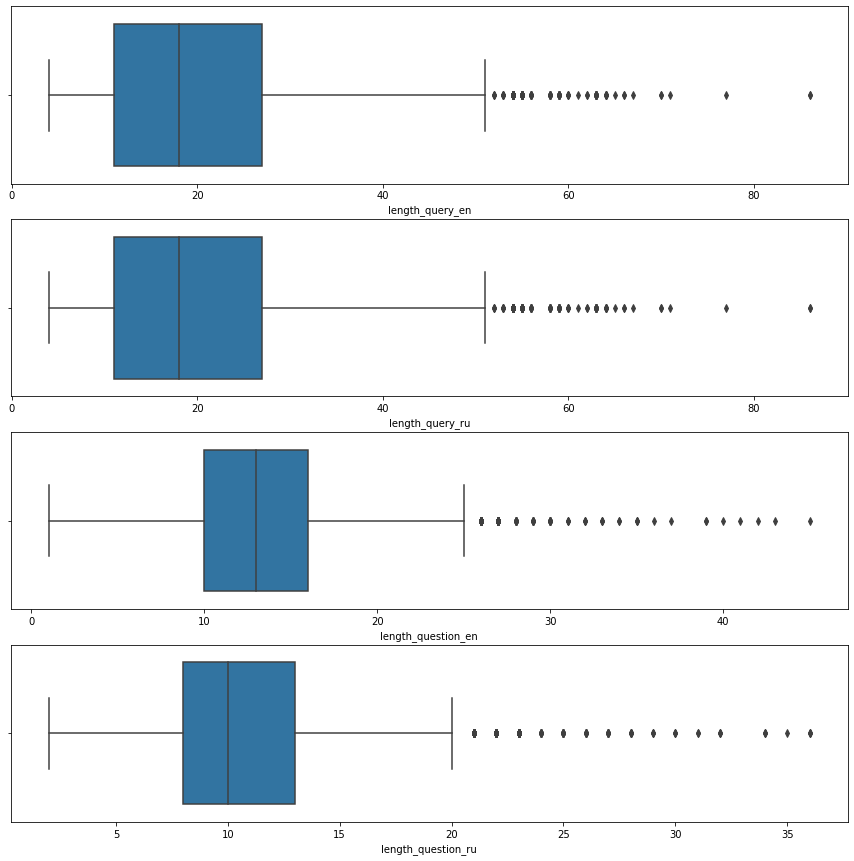

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(15, 15))

sns.boxplot(ax=axes[0], x='length_query_en', data=pauq_data)
sns.boxplot(ax=axes[1], x='length_query_ru', data=pauq_data)
sns.boxplot(ax=axes[2], x='length_question_en', data=pauq_data)
sns.boxplot(ax=axes[3], x='length_question_ru', data=pauq_data)

In [ ]:
pauq_data[pauq_data['length_question_en'] < 3]

,id,db_id,source,type,query_en,query_ru,question_en,question_ru,query_toks_en,query_toks_ru,query_toks_no_values_en,query_toks_no_values_ru,question_toks_en,question_toks_ru,length_query_en,length_query_ru,length_question_en,length_question_ru
7604,TO_7605,scholar,spider-train-others,train,SELECT DISTINCT t1.paperid FROM venue AS t2 JO...,SELECT DISTINCT t1.paperid FROM venue AS t2 JO...,chi papers,Работы опубликованные в Просвещении,"[select, distinct, t1.paperid, from, venue, as...","[select, distinct, t1.paperid, from, venue, as...","[select, distinct, t1.paperid, from, venue, as...","[select, distinct, t1.paperid, from, venue, as...","[chi, papers]","[Работы, опубликованные, в, Просвещении]",20,20,2,4
7607,TO_7608,scholar,spider-train-others,train,SELECT DISTINCT t1.paperid FROM venue AS t2 JO...,SELECT DISTINCT t1.paperid FROM venue AS t2 JO...,chi,Просвещение работы,"[select, distinct, t1.paperid, from, venue, as...","[select, distinct, t1.paperid, from, venue, as...","[select, distinct, t1.paperid, from, venue, as...","[select, distinct, t1.paperid, from, venue, as...",[chi],"[Просвещение, работы]",20,20,1,2
7749,TO_7750,scholar,spider-train-others,train,SELECT DISTINCT t3.paperid FROM writes AS t2 J...,SELECT DISTINCT t3.paperid FROM writes AS t2 J...,subhasis chaudhuri,Статьи автора Демида Полякова,"[select, distinct, t3.paperid, from, writes, a...","[select, distinct, t3.paperid, from, writes, a...","[select, distinct, t3.paperid, from, writes, a...","[select, distinct, t3.paperid, from, writes, a...","[subhasis, chaudhuri]","[Статьи, автора, Демида, Полякова]",28,28,2,4
7957,TO_7958,scholar,spider-train-others,train,SELECT DISTINCT paperid FROM paper WHERE YEAR ...,SELECT DISTINCT paperid FROM paper WHERE YEAR ...,2014 papers,Статьи 2014 г. публикации,"[select, distinct, paperid, from, paper, where...","[select, distinct, paperid, from, paper, where...","[select, distinct, paperid, from, paper, where...","[select, distinct, paperid, from, paper, where...","[2014, papers]","[Статьи, 2014, г., публикации]",10,10,2,4
7982,TO_7983,scholar,spider-train-others,train,SELECT DISTINCT t3.paperid FROM paperdataset A...,SELECT DISTINCT t3.paperid FROM paperdataset A...,WebKB papers,Статьи с WebKB,"[select, distinct, t3.paperid, from, paperdata...","[select, distinct, t3.paperid, from, paperdata...","[select, distinct, t3.paperid, from, paperdata...","[select, distinct, t3.paperid, from, paperdata...","[WebKB, papers]","[Статьи, с, WebKB]",28,28,2,3
8054,TO_8055,scholar,spider-train-others,train,SELECT DISTINCT t1.authorid FROM venue AS t3 J...,SELECT DISTINCT t1.authorid FROM venue AS t3 J...,NIPS authors,Авторы nips,"[select, distinct, t1.authorid, from, venue, a...","[select, distinct, t1.authorid, from, venue, a...","[select, distinct, t1.authorid, from, venue, a...","[select, distinct, t1.authorid, from, venue, a...","[NIPS, authors]","[Авторы, nips]",28,28,2,2


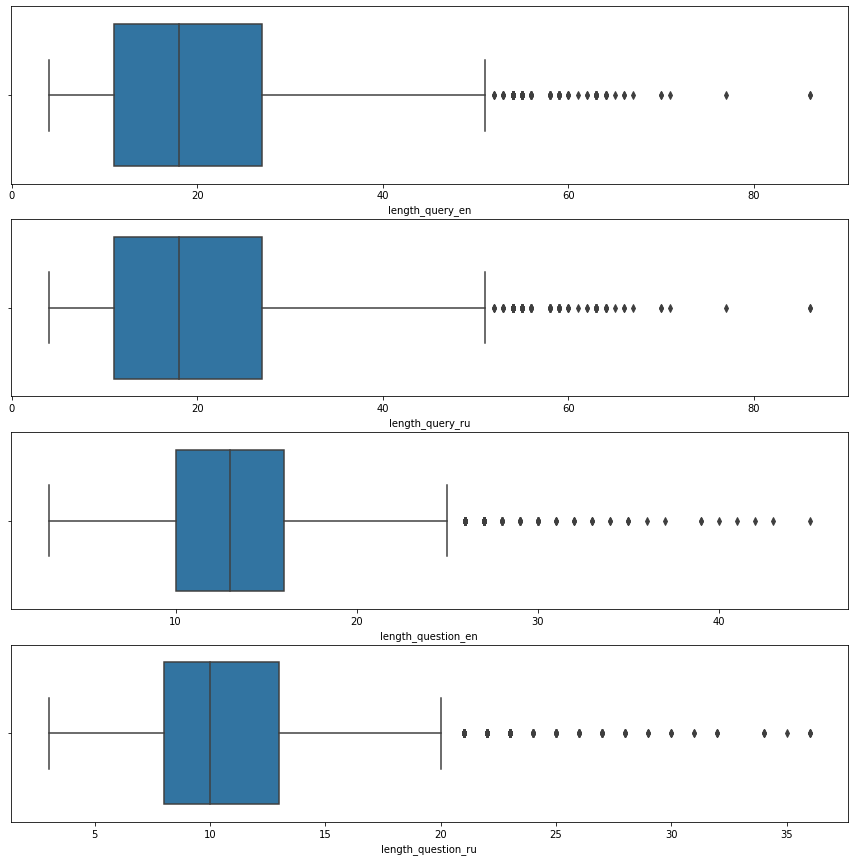

In [ ]:
pauq_data = pauq_data[(pauq_data['length_question_en'] > 2) & (pauq_data['length_question_ru'] > 2)]

fig, axes = plt.subplots(4, 1, figsize=(15, 15))

sns.boxplot(ax=axes[0], x='length_query_en', data=pauq_data)
sns.boxplot(ax=axes[1], x='length_query_ru', data=pauq_data)
sns.boxplot(ax=axes[2], x='length_question_en', data=pauq_data)
sns.boxplot(ax=axes[3], x='length_question_ru', data=pauq_data)

In [ ]:
pauq_data[['length_query_en', 'length_query_ru', 'length_question_en', 'length_question_ru']].describe()

,length_query_en,length_query_ru,length_question_en,length_question_ru
count,8791.000000,8791.000000,8791.000000,8791.000000
mean,20.284154,20.265044,13.195427,10.608122
std,11.219387,11.198450,4.870662,4.174888
min,4.000000,4.000000,3.000000,3.000000
25%,11.000000,11.000000,10.000000,8.000000
50%,18.000000,18.000000,13.000000,10.000000
75%,27.000000,27.000000,16.000000,13.000000
max,86.000000,86.000000,45.000000,36.000000


#### Сохранение наборов данных

In [ ]:
# train and eval
pauq_data['query_en'] = pauq_data['query_toks_en'].apply(lambda x: ' '.join(x))
pauq_data['question_en'] = pauq_data['question_en']

pauq_data['query_ru'] = pauq_data['query_toks_ru'].apply(lambda x: ' '.join(x))
pauq_data['question_ru'] = pauq_data['question_ru']

# test
pauq_test = pd.DataFrame(data_gen(dataset_name_pauq, [pauq_dev]))
pauq_test['query_en'] = pauq_test['query_toks_en'].apply(lambda x: ' '.join(x))
pauq_test['question_en'] = pauq_test['question_en']

pauq_test['query_ru'] = pauq_test['query_toks_ru'].apply(lambda x: ' '.join(x))
pauq_test['question_ru'] = pauq_test['question_ru']

# сохранение наборов данных
X_train, X_eval = train_test_split(pauq_data[['query_en', 'question_en', 'query_ru', 'question_ru']], test_size=1_000, random_state=42)

X_train.to_csv('train.csv', index=False, encoding='utf-8')
X_eval.to_csv('eval.csv', index=False, encoding='utf-8')
pauq_test[['query_en', 'question_en', 'query_ru', 'question_ru']].to_csv('test.csv', index=False, encoding='utf-8')

In [ ]:
!cp /content/train.csv "/content/drive/MyDrive/course_work/train.csv"
!cp /content/eval.csv "/content/drive/MyDrive/course_work/eval.csv"
!cp /content/test.csv "/content/drive/MyDrive/course_work/test.csv"

#### Дообучение моделей

##### Суммаризация на русском языке

###### Fine-tuning модели mbart-large-cc25

In [ ]:
!cp "/content/drive/MyDrive/course_work/train.csv" /content/train.csv
!cp "/content/drive/MyDrive/course_work/eval.csv" /content/eval.csv
!cp "/content/drive/MyDrive/course_work/test.csv"  /content/test.csv

In [ ]:
SEED = 3
src_lang = 'en_XX'
tgt_lang = 'ru_RU'
set_seed(SEED)

In [ ]:
dataset = load_dataset("csv", data_files={'train': 'train.csv', 'eval': 'eval.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4b3d8e45e51f037d/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['train'][0]

{'query_en': 'select transaction_type_code , avg ( amount_of_transaction ) from transactions group by transaction_type_code ;',
 'question_en': 'Show the average transaction amount for different transaction types.',
 'query_ru': 'select transaction_type_code , avg ( amount_of_transaction ) from transactions group by transaction_type_code ;',
 'question_ru': 'Показать среднюю сумму транзакции для разных типов транзакций.'}

In [ ]:
model_name = "facebook/mbart-large-cc25"

config = transformers.AutoConfig.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config)

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

In [ ]:
model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(tgt_lang)

In [ ]:
tokenizer.src_lang = src_lang
tokenizer.tgt_lang = tgt_lang

# Для mbart нужен токен языка
forced_bos_token_id = (tokenizer.lang_code_to_id[tgt_lang])

model.config.forced_bos_token_id = forced_bos_token_id

In [ ]:
text_column = 'query_ru'
summary_column = 'question_ru'

In [ ]:
max_source_length = 120
max_target_length = 80
padding = 'max_length'
ignore_pad_token_for_loss = True

In [ ]:
def preprocess_function(examples):
  inputs, targets = [], []

  for i in range(len(examples[text_column])):
      if examples[text_column][i] and examples[summary_column][i]:
          inputs.append(examples[text_column][i])
          targets.append(examples[summary_column][i])

  model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

  labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

  # Для игнорирования паддинга в loss
  if padding == "max_length" and ignore_pad_token_for_loss:
      labels["input_ids"] = [
          [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
      ]

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [ ]:
train_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=['query_ru', 'question_ru', 'query_en', 'question_en'],
    )

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# Data collator
label_pad_token_id = -100 
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id
)

In [ ]:
# Метрика
metric = evaluate.load("bleu")

In [ ]:
def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]
  
  return preds, labels

In [ ]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
  result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenizer=lambda x: x.split(), max_order=4, smooth=True)

  return {'bleu': round(result['bleu'] * 100, 4)}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    evaluation_strategy='epoch',
    num_train_epochs=1,
    output_dir='test_trainer',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    optim="adafactor",
    predict_with_generate=True
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

train_result = trainer.train()

***** Running training *****
  Num examples = 7791
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 487
  Number of trainable parameters = 610851840
You're using a MBartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu
1,1.209900,1.100053,12.906400


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




###### Оценка качества настроенного mBART на тестовом наборе данных

In [ ]:
predict_results = trainer.predict(
    train_dataset['test'],
    metric_key_prefix="predict",
    max_length=max_target_length,
    num_beams=3
)

***** Running Prediction *****
  Num examples = 1076
  Batch size = 16


In [ ]:
metrics = predict_results.metrics
metrics

{'predict_loss': 1.3692773580551147,
 'predict_bleu': 8.8664,
 'predict_runtime': 127.51,
 'predict_samples_per_second': 8.439,
 'predict_steps_per_second': 0.533}

In [ ]:
predictions = []
if trainer.is_world_process_zero():
  if training_args.predict_with_generate:
    predictions = tokenizer.batch_decode(
        predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    predictions = [pred.strip() for pred in predictions]

In [ ]:
output_prediction_file = "generated_predictions_mbart_ru.txt"
with open(output_prediction_file, "w") as writer:
  writer.write("\n".join(predictions))

In [ ]:
for i in range(0, 61, 15):
  print(i)
  print('sql запрос: ', dataset['test'][i]['query_ru'])
  print('оригинальный вопрос: ', dataset['test'][i]['question_ru'])
  print('предсказанный вопрос: ', predictions[i], '\n')

0
sql запрос:  select count ( * ) from singer ;
оригинальный вопрос:  Сколько у нас певцов?
предсказанный вопрос:  Какое общее количество исполнителей? 

15
sql запрос:  select location , name from stadium where capacity between 5000 and 10000 ;
оригинальный вопрос:  Каково расположение и названия всех станций вместимостью от 5000 до 10000?
предсказанный вопрос:  Найдите местоположения и названия стадионов с вместимостью от 5000 до 10000 человек. 

30
sql запрос:  select country from singer where age > 40 intersect select country from singer where age < 30 ;
оригинальный вопрос:  Показать страны происхождения певца старше 40 лет и певца младше 30 лет.
предсказанный вопрос:  Найдите страны, в которых есть исполнители старше 40 лет и исполнители младше 30 лет. 

45
sql запрос:  select count ( * ) from pets where weight > 10 ;
оригинальный вопрос:  Найдите количество домашних животных, вес которых превышает 10.
предсказанный вопрос:  Найдите количество домашних животных весом более 10 кг.

###### Fine-tuning модели mt5-base

In [ ]:
!cp "/content/drive/MyDrive/course_work/train.csv" /content/train.csv
!cp "/content/drive/MyDrive/course_work/eval.csv" /content/eval.csv
!cp "/content/drive/MyDrive/course_work/test.csv"  /content/test.csv

In [ ]:
SEED = 3
src_lang = 'en_XX'
tgt_lang = 'ru_RU'
set_seed(SEED)

In [ ]:
dataset = load_dataset("csv", data_files={'train': 'train.csv', 'eval': 'eval.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b4ce56d602cd2f8c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['train'][0]

{'query_en': 'select transaction_type_code , avg ( amount_of_transaction ) from transactions group by transaction_type_code ;',
 'question_en': 'Show the average transaction amount for different transaction types.',
 'query_ru': 'select transaction_type_code , avg ( amount_of_transaction ) from transactions group by transaction_type_code ;',
 'question_ru': 'Показать среднюю сумму транзакции для разных типов транзакций.'}

In [ ]:
model_name = "google/mt5-base"

config = AutoConfig.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config)

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Downloading:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

In [ ]:
model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(tgt_lang)

In [ ]:
prefix = 'summarize: '

In [ ]:
tokenizer.src_lang = src_lang
tokenizer.tgt_lang = tgt_lang

In [ ]:
text_column = 'query_ru'
summary_column = 'question_ru'

In [ ]:
max_source_length = 120
max_target_length = 80
padding = 'max_length'
ignore_pad_token_for_loss = True

In [ ]:
def preprocess_function(examples):
  inputs, targets = [], []

  for i in range(len(examples[text_column])):
      if examples[text_column][i] and examples[summary_column][i]:
          inputs.append(examples[text_column][i])
          targets.append(examples[summary_column][i])
  
  inputs = [prefix + inp for inp in inputs]
  model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

  labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

  # Для игнорирования паддинга в loss
  if padding == "max_length" and ignore_pad_token_for_loss:
      labels["input_ids"] = [
          [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
      ]

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [ ]:
train_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=['query_ru', 'question_ru', 'query_en', 'question_en'],
    )

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# Data collator
label_pad_token_id = -100 
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id
)

In [ ]:
# Метрика
metric = evaluate.load("bleu")

In [ ]:
def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]
  
  return preds, labels

In [ ]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
  result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenizer=lambda x: x.split(), max_order=4, smooth=True)

  return {'bleu': round(result['bleu'] * 100, 4)}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    evaluation_strategy='epoch',
    num_train_epochs=2,
    output_dir='test_trainer',
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    optim="adafactor",
    predict_with_generate=True
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

train_result = trainer.train()

***** Running training *****
  Num examples = 7791
  Num Epochs = 2
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 1560
  Number of trainable parameters = 582401280
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu
1,4.680600,1.617687,2.677100
2,2.083300,1.484831,3.710500


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-500/special_tokens_map.json
Copy vocab file to test_trainer/checkpoint-500/spiece.model
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 10
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-1000/special_tokens_map.json
Copy vocab file to test_trainer/checkpoint-1000/spiece.model
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-15

###### Оценка качества настроенного mT5 на тестовом наборе данных

In [ ]:
predict_results = trainer.predict(
    train_dataset['test'],
    metric_key_prefix="predict",
    max_length=max_target_length,
    num_beams=3
)

***** Running Prediction *****
  Num examples = 1076
  Batch size = 10


In [ ]:
metrics = predict_results.metrics
metrics

{'predict_loss': 1.6007243394851685,
 'predict_bleu': 5.0035,
 'predict_runtime': 148.2517,
 'predict_samples_per_second': 7.258,
 'predict_steps_per_second': 0.728}

In [ ]:
predictions = []
if trainer.is_world_process_zero():
  if training_args.predict_with_generate:
    predictions = tokenizer.batch_decode(
        predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    predictions = [pred.strip() for pred in predictions]

In [ ]:
output_prediction_file = "generated_predictions_mt5_ru.txt"
with open(output_prediction_file, "w") as writer:
  writer.write("\n".join(predictions))

In [ ]:
for i in range(0, 61, 15):
  print(i)
  print('sql запрос: ', dataset['test'][i]['query_ru'])
  print('оригинальный вопрос: ', dataset['test'][i]['question_ru'])
  print('предсказанный вопрос: ', predictions[i], '\n')

0
sql запрос:  select count ( * ) from singer ;
оригинальный вопрос:  Сколько у нас певцов?
предсказанный вопрос:  Найдите количество исполнителей, у которых есть песни. 

15
sql запрос:  select location , name from stadium where capacity between 5000 and 10000 ;
оригинальный вопрос:  Каково расположение и названия всех станций вместимостью от 5000 до 10000?
предсказанный вопрос:  Найдите место и названия стадионов, в которых есть вместимость более 5000 и 10000. 

30
sql запрос:  select country from singer where age > 40 intersect select country from singer where age < 30 ;
оригинальный вопрос:  Показать страны происхождения певца старше 40 лет и певца младше 30 лет.
предсказанный вопрос:  Каковы страны, в которых есть певцы, которые более 40 лет? 

45
sql запрос:  select count ( * ) from pets where weight > 10 ;
оригинальный вопрос:  Найдите количество домашних животных, вес которых превышает 10.
предсказанный вопрос:  Найдите количество pets, вес которых менее 10 кг. 

60
sql запрос:

##### Суммаризация на английском языке

###### Fine-tuning модели bart-large

In [4]:
!cp "/content/drive/MyDrive/course_work/train.csv" /content/train.csv
!cp "/content/drive/MyDrive/course_work/eval.csv" /content/eval.csv
!cp "/content/drive/MyDrive/course_work/test.csv"  /content/test.csv

In [5]:
SEED = 3
set_seed(SEED)

In [6]:
dataset = load_dataset("csv", data_files={'train': 'train.csv', 'eval': 'eval.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8e7775a8f386e98d/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
model_name = "facebook/bart-large"

config = transformers.AutoConfig.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config)

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

In [9]:
text_column = 'query_en'
summary_column = 'question_en'

In [10]:
max_source_length = 120
max_target_length = 80
padding = 'max_length'
ignore_pad_token_for_loss = True

In [11]:
def preprocess_function(examples):
  inputs, targets = [], []

  for i in range(len(examples[text_column])):
      if examples[text_column][i] and examples[summary_column][i]:
          inputs.append(examples[text_column][i])
          targets.append(examples[summary_column][i])

  model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

  labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

  # Для игнорирования паддинга в loss
  if padding == "max_length" and ignore_pad_token_for_loss:
      labels["input_ids"] = [
          [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
      ]

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [12]:
train_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=['query_ru', 'question_ru', 'query_en', 'question_en'],
    )

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
# Data collator
label_pad_token_id = -100 
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id
)

In [14]:
# Метрика
metric = evaluate.load("bleu")

In [15]:
def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]
  
  return preds, labels

In [16]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
  result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenizer=lambda x: x.split(), max_order=4, smooth=True)

  return {'bleu': round(result['bleu'] * 100, 4)}

In [17]:
training_args = Seq2SeqTrainingArguments(
    evaluation_strategy='epoch',
    num_train_epochs=1,
    output_dir='test_trainer',
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    warmup_steps=100,
    optim="adafactor",
    predict_with_generate=True
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

train_result = trainer.train()

***** Running training *****
  Num examples = 7791
  Num Epochs = 1
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 1
  Total optimization steps = 325
  Number of trainable parameters = 406291456
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu
1,No log,1.113081,27.777900


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)




###### Оценка качества настроенного bart-large на тестовом наборе данных

In [18]:
predict_results = trainer.predict(
    train_dataset['test'],
    metric_key_prefix="predict",
    max_length=max_target_length,
    num_beams=3
)

***** Running Prediction *****
  Num examples = 1076
  Batch size = 24


In [19]:
metrics = predict_results.metrics
metrics

{'predict_loss': 1.2719581127166748,
 'predict_bleu': 25.053,
 'predict_runtime': 88.872,
 'predict_samples_per_second': 12.107,
 'predict_steps_per_second': 0.506}

In [20]:
predictions = []
if trainer.is_world_process_zero():
  if training_args.predict_with_generate:
    predictions = tokenizer.batch_decode(
        predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    predictions = [pred.strip() for pred in predictions]

In [21]:
output_prediction_file = "generated_predictions_bart_en.txt"
with open(output_prediction_file, "w") as writer:
  writer.write("\n".join(predictions))

In [22]:
for i in range(0, 61, 15):
  print(i)
  print('sql запрос: ', dataset['test'][i]['query_en'])
  print('оригинальный вопрос: ', dataset['test'][i]['question_en'])
  print('предсказанный вопрос: ', predictions[i], '\n')

0
sql запрос:  select count ( * ) from singer ;
оригинальный вопрос:  How many singers do we have?
предсказанный вопрос:  How many singers are there? 

15
sql запрос:  select location , name from stadium where capacity between 5000 and 10000 ;
оригинальный вопрос:  What are the locations and names of all stations with capacity between 5000 and 10000?
предсказанный вопрос:  What are the locations and names of stadiums with capacity between 5000 and 10000? 

30
sql запрос:  select country from singer where age > 40 intersect select country from singer where age < 30 ;
оригинальный вопрос:  Show countries where a singer above age 40 and a singer below 30 are from.
предсказанный вопрос:  What are the countries that have both singers older than 40 and singers younger than 30? 

45
sql запрос:  select count ( * ) from pets where weight > 10 ;
оригинальный вопрос:  Find the number of pets whose weight is heavier than 10.
предсказанный вопрос:  How many pets have a weight greater than 10? 

60

###### Fine-tuning модели Salesforce/codet5-base-multi-sum

In [ ]:
!cp "/content/drive/MyDrive/course_work/train.csv" /content/train.csv
!cp "/content/drive/MyDrive/course_work/eval.csv" /content/eval.csv
!cp "/content/drive/MyDrive/course_work/test.csv"  /content/test.csv

In [ ]:
SEED = 3
set_seed(SEED)

In [ ]:
dataset = load_dataset("csv", data_files={'train': 'train.csv', 'eval': 'eval.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a212505ba26db1b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model_name = "Salesforce/codet5-base-multi-sum"

config = AutoConfig.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config)

Downloading:   0%|          | 0.00/902 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/703k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/294k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
text_column = 'query_en'
summary_column = 'question_en'

In [ ]:
max_source_length = 120
max_target_length = 80
padding = 'max_length'
ignore_pad_token_for_loss = True

In [ ]:
def preprocess_function(examples):
  inputs, targets = [], []

  for i in range(len(examples[text_column])):
      if examples[text_column][i] and examples[summary_column][i]:
          inputs.append(examples[text_column][i])
          targets.append(examples[summary_column][i])
  
  model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

  labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

  # Для игнорирования паддинга в loss
  if padding == "max_length" and ignore_pad_token_for_loss:
      labels["input_ids"] = [
          [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
      ]

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [ ]:
train_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=['query_ru', 'question_ru', 'query_en', 'question_en'],
    )

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# Data collator
label_pad_token_id = -100 
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id
)

In [ ]:
# Метрика
metric = evaluate.load("bleu")

In [ ]:
def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]
  
  return preds, labels

In [ ]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
  result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenizer=lambda x: x.split(), max_order=4, smooth=True)

  return {'bleu': round(result['bleu'] * 100, 4)}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    evaluation_strategy='epoch',
    num_train_epochs=1,
    output_dir='test_trainer',
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    warmup_steps=100,
    optim="adafactor",
    predict_with_generate=True
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

train_result = trainer.train()

***** Running training *****
  Num examples = 7791
  Num Epochs = 1
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 1
  Total optimization steps = 325
  Number of trainable parameters = 222882048
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu
1,No log,1.247234,23.719400


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)




###### Оценка качества настроенного codet5-base-multi-sum на тестовом наборе данных

In [ ]:
predict_results = trainer.predict(
    train_dataset['test'],
    metric_key_prefix="predict",
    max_length=max_target_length,
    num_beams=3
)

***** Running Prediction *****
  Num examples = 1076
  Batch size = 24


In [ ]:
metrics = predict_results.metrics
metrics

{'predict_loss': 1.4516271352767944,
 'predict_bleu': 23.0288,
 'predict_runtime': 69.0454,
 'predict_samples_per_second': 15.584,
 'predict_steps_per_second': 0.652}

In [ ]:
predictions = []
if trainer.is_world_process_zero():
  if training_args.predict_with_generate:
    predictions = tokenizer.batch_decode(
        predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    predictions = [pred.strip() for pred in predictions]

In [ ]:
output_prediction_file = "generated_predictions_codet5_base_en.txt"
with open(output_prediction_file, "w") as writer:
  writer.write("\n".join(predictions))

In [ ]:
for i in range(0, 61, 15):
  print(i)
  print('sql запрос: ', dataset['test'][i]['query_en'])
  print('оригинальный вопрос: ', dataset['test'][i]['question_en'])
  print('предсказанный вопрос: ', predictions[i], '\n')

0
sql запрос:  select count ( * ) from singer ;
оригинальный вопрос:  How many singers do we have?
предсказанный вопрос:  How many singers are there? 

15
sql запрос:  select location , name from stadium where capacity between 5000 and 10000 ;
оригинальный вопрос:  What are the locations and names of all stations with capacity between 5000 and 10000?
предсказанный вопрос:  What are the locations and names of all stadiums with capacity between 5000 and 10000? 

30
sql запрос:  select country from singer where age > 40 intersect select country from singer where age < 30 ;
оригинальный вопрос:  Show countries where a singer above age 40 and a singer below 30 are from.
предсказанный вопрос:  What are the countries that have more than 40 and less than 30 singers? 

45
sql запрос:  select count ( * ) from pets where weight > 10 ;
оригинальный вопрос:  Find the number of pets whose weight is heavier than 10.
предсказанный вопрос:  How many pets have weight greater than 10? 

60
sql запрос:  s